# Importiere Daten


In [17]:
import numpy as np
import pandas as pd
import geopandas as gp
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os as os

## Funktionen definieren

In [18]:
def select_every_12th_with_start(arr, start_index):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 11")

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])
    
    return selected_elements

def linear_reg(x, m, t):
    return m*x + t

def generate_counting_array(length):
    return np.arange(length)

    
def selecting_month(arr, start_index, start_date, end_date):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 12")  # Change 11 to 12

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])

    tmp = xr.concat(selected_elements, dim="time")  # Concatenate the selected elements
    tmp = tmp.sel(time=slice(start_date, end_date))
    
    return tmp


def fit_count(arr):
    return generate_counting_array(len(arr))



def selecting_tf(arr,start_time, end_time):
    return arr.sel(time = slice(start_time, end_time))

def LinReg_All_Month(arr, time_start_displayed, time_start_fit, time_end, Name, Ordnername):
    # Create an empty DataFrame
    columns = ['month', 'slope', 'offset', 'var']
    parameters_df = pd.DataFrame(columns=columns)

    # Set 'month' as the index
    parameters_df.set_index('month', inplace=True)

    for month in range(1,13):
        # Select data

        y_data = selecting_month(arr,month, time_start_displayed, time_end)

        #Selecting fitting data
        y_temp = selecting_tf(y_data, time_start_fit, time_end)
        x_temp = fit_count(y_temp)

        #Fitting
        par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)

        #Producing fitting output
        y_fit = linear_reg(x_temp, *par_LinReg)
        x_fit = y_temp['time'].values


        plt.plot(y_temp['time'].values, y_temp)
        plt.plot(y_data['time'].values, y_data, marker = 'x', ls = '', label = 'data')
        plt.plot(x_fit, y_fit, alpha = .5, label = 'LinReg')

        #Calculating Varriance

        VarDeltaT = np.var(y_temp-y_fit)

        #Adding to df
        new_entry = {'slope': par_LinReg[0]*50, 'offset': par_LinReg[1], 'var': VarDeltaT.values}
        parameters_df.loc[str(month)] = new_entry


        plt.xlabel('time')
        plt.ylabel('DTR')

        plt.title(Name + 'entire pol. reg. in month ' + str(month))

        plt.xlim(time_values[800], time_values[-1])
        plt.legend()
        # Add a subtle background color
        plt.gca().set_facecolor((0.95, 0.95, 0.95))

        # Display the plot
        plt.tight_layout()

        if not os.path.exists(name_region + name_breitengrad + Ordnername):
            os.mkdir(name_region + name_breitengrad + Ordnername)
        plt.savefig(name_region + name_breitengrad + Ordnername +Name+'_Month_'+ str(month)+'.png', dpi = 300)
        plt.clf()
    return parameters_df

# def LinReg_Month(arr, time_start_displayed, time_start_fit, time_end, month):


#     y_data = selecting_month(arr,month, time_start_displayed, time_end)

#     #Selecting fitting data
#     y_temp = selecting_tf(y_data, time_start_fit, time_end)
#     x_temp = fit_count(y_temp)

#     #Fitting
#     par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)

    
    

#     #Calculating Varriance

#     VarDeltaT = np.var(y_temp-y_fit)

#     return par_LinReg, VarDeltaT


def generate_cosine_weight(angles):
    temp = np.cos(np.radians(angles))
    cosine_values = temp/np.sum(temp)
    return cosine_values

### Gewichtung der Daten

In [19]:
def weigth(arr):
    return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

def TMax_selection(grad_min, grad_max):
    selected_data = TMax_Lat.sel(lat=slice(grad_min, grad_max)).tmx
    
    if np.isnan(selected_data).any():
        print('There is a Nan-Entry in your Max data selected!')
        return None
    else:
        weights = generate_cosine_weight(selected_data['lat'].values)
        result = np.dot(selected_data, weights)
        result_data_array = xr.DataArray(result, coords={'time': selected_data['time']}, dims=['time'])
        return result_data_array

def TMin_selection(grad_min, grad_max):
    selected_data = TMin_Lat.sel(lat=slice(grad_min, grad_max))
    
    if np.isnan(selected_data.tmn).any():
        print('There is a Nan-Entry in your Min data selected!')
        return None
    else:
        weights = generate_cosine_weight(selected_data['lat'].values)
        result = np.dot(selected_data.tmn, weights)
        result_data_array = xr.DataArray(result, coords={'time': selected_data['time']}, dims=['time'])
        return result_data_array

def temperature_diff_selection(grad_min, grad_max):
    tmax_result = TMax_selection(grad_min, grad_max)
    tmin_result = TMin_selection(grad_min, grad_max)
    
    if tmax_result is not None and tmin_result is not None:
        return tmax_result - tmin_result
    else:
        return None


## Speicherorte verwalten

## Daten importieren

In [20]:
# File paths
TMin_file = 'data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'data\cru_ts4.07.1901.2022.tmp.dat.nc\cru_ts4.07.1901.2022.tmp.dat.nc'

# Load datasets
TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg =  xr.open_dataset(TAvg_file)

## Differenz berechnen

In [21]:



time_values = TMax['time'].values
lon_values = TMax['lon'].values
lat_values = TMax['lat'].values

#Graphischen Layout
colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'magenta', 'pink', 'brown', 'olive', 'gray']
month_label = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [22]:
temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt

temperature_difference_selection = temperature_difference.sel(lat = slice(66, 84))

time_values = temperature_difference_selection['time'].values
lon_values = temperature_difference_selection['lon'].values
lat_values = temperature_difference_selection['lat'].values


## Plots

In [23]:

name_region = 'NordPolGroenRechts/'

if not os.path.exists(name_region):
    os.mkdir(name_region)
# Zu betrachtender Bereich 
    #Zeit
t_s_d = '1973-01-15T00:00:00.000000000'
t_s_f = '1973-01-15T00:00:00.000000000'  #Time to start fitting
t_e = time_values[-1]
    #Ort
lon_min = 80
lon_max = 82

name_breitengrad = 'Lon_'+str(lon_min)+'_'+str(lon_max)+'/'
if not os.path.exists(name_region+name_breitengrad):
    os.mkdir(name_region+name_breitengrad)


Generate Data Frame for the fit values


In [24]:
# Define the dimensions and coordinate values
data_array = np.full((len(lat_values), len(lon_values)), np.nan)

# Create the DataArray with coordinates
data_fit = xr.DataArray(
    data_array,
    dims=["lat", "lon"],  # Order of dimensions matters!
    coords={"lon": lon_values, "lat": lat_values},
)

print(data_fit)

<xarray.DataArray (lat: 36, lon: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 66.25 66.75 67.25 67.75 ... 82.25 82.75 83.25 83.75


Fitting the array

In [25]:
def LinReg_Month(arr,lon_v, lat_v, time_start_displayed, time_start_fit, time_end, month):

    data = arr.sel(lon = lon_v, lat = lat_v)
    
    if any(np.isnan(data)):
        return np.nan
    
    else:
        y_data = selecting_month(data,month, time_start_displayed, time_end)

        #Selecting fitting data
        y_temp = selecting_tf(y_data, time_start_fit, time_end)
        x_temp = fit_count(y_temp)

        #Fitting
        par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)

        
        

        #Calculating Varriance

       # VarDeltaT = np.var(y_temp-y_fit)

        return par_LinReg[0]

# print(len(lat_values[slice(66,84)]))

# data_fit.loc[{'lon': lon_values[0], 'lat': lat_values[0]}] = 1

# print(data_fit)


# print(lon_values)
# print(temperature_difference.sel(lon = -27.75, lat = 70.25))

for mon in [9,12]:
    for lon in lon_values:
        for lat in lat_values:
            data_fit.loc[{'lon': lon, 'lat': lat}] = LinReg_Month(TMin.tmn, lon_v= lon, lat_v= lat, time_start_displayed= t_s_f, time_start_fit= t_s_f, time_end= t_e, month = mon)        
    data_fit.to_netcdf('Fit_data_TMin_month_' +str(mon)+'.nc')
    print('Monat: '+str(mon))

Monat: 9


KeyboardInterrupt: 

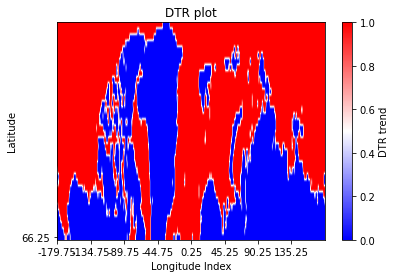

In [ ]:
#data_fit.to_netcdf('my_Fit_data_month9.nc')

# print(temperature_difference)
isnan_plot = np.isnan(data_fit)

plt.imshow(isnan_plot, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='DTR trend')
plt.title('DTR plot')

# Get the latitudes for the y-axis
latitudes = isnan_plot['lat'].values
longitude = isnan_plot['lon'].values

# Set the y ticks using the latitudes
plt.yticks(range(len(latitudes))[::50], latitudes[::50])
plt.xticks(range(len(longitude))[::90], longitude[::90])

plt.clim(0,1)

plt.xlabel('Longitude Index')
plt.ylabel('Latitude')
#plt.savefig('datacoverage.pdf', dpi = 300)
plt.show()


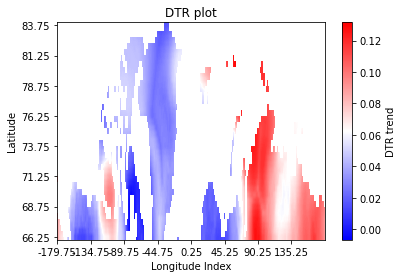

In [ ]:
# print(temperature_difference)
isnan_plot = np.isnan(data_fit)


plt.imshow(data_fit, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='DTR trend')
plt.title('DTR plot')

# Get the latitudes for the y-axis
latitudes = isnan_plot['lat'].values
longitude = isnan_plot['lon'].values

# Set the y ticks using the latitudes
plt.yticks(range(len(latitudes))[::5], latitudes[::5])
plt.xticks(range(len(longitude))[::90], longitude[::90])

# plt.clim,)

plt.xlabel('Longitude Index')
plt.ylabel('Latitude')
#plt.savefig('datacoverage.pdf', dpi = 300)
plt.show()

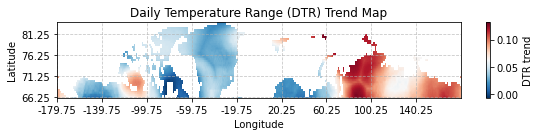

In [ ]:
plt.figure(figsize=(8,2))
plt.imshow(data_fit, cmap='RdBu_r', origin='lower', aspect='auto')
plt.colorbar(label='DTR trend')
plt.title('Daily Temperature Range (DTR) Trend Map')

# Get the latitudes for the y-axis
latitudes = isnan_plot['lat'].values
longitude = isnan_plot['lon'].values

# Set the y ticks using the latitudes (adjust the frequency as needed)
plt.yticks(np.arange(0, len(latitudes), 10), latitudes[::10])
plt.xticks(np.arange(0, len(longitude), 80), longitude[::80])

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the figure (uncomment the line below to save)
# plt.savefig('datacoverage.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
#plt.savefig('Arktiktis_TMin_entwicklung_Unverzerrt_month_3.pdf')
plt.show()

In [ ]:
month = 9
data = temperature_difference.sel(lon = -27.75, lat = 70.25)
if any(np.isnan(data)):
    print('here!')
    
else:
    y_data = selecting_month(data,month, t_s_d, t_e)
    #Selecting fitting data
    y_temp = selecting_tf(y_data, t_s_f, t_e)
    x_temp = fit_count(y_temp)
    #Fitting
    par_LinReg, cov_LinReg = curve_fit(linear_reg, x_temp ,y_temp)
    
    #Calculating Varriance
    # VarDeltaT = np.var(y_temp-y_fit)
    print(par_LinReg[0]*50)
    print('yeah')

0.11044424968887356
yeah


Where is nan

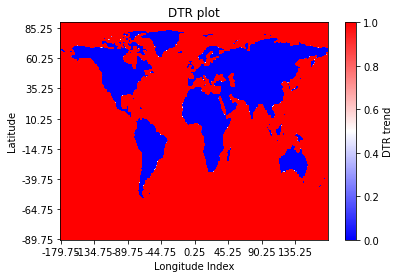

In [ ]:
# print(temperature_difference)
isnan_array = np.isnan(temperature_difference)
print()

isnan_plot = isnan_array.sum(dim='time')

plt.imshow(isnan_plot, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='DTR trend')
plt.title('DTR plot')

# Get the latitudes for the y-axis
latitudes = isnan_plot['lat'].values
longitude = isnan_plot['lon'].values

# Set the y ticks using the latitudes
plt.yticks(range(len(latitudes))[::50], latitudes[::50])
plt.xticks(range(len(longitude))[::90], longitude[::90])

plt.clim(0,1)

plt.xlabel('Longitude Index')
plt.ylabel('Latitude')
#plt.savefig('datacoverage.pdf', dpi = 300)
plt.show()


In [ ]:
x_test = [1, 20]
y_test = [2, 4]

data_array = np.full((len(x_test), len(y_test)), np.nan)

# Create the DataArray with coordinates
data_fit_expample = xr.DataArray(
    data_array,
    dims=["lon", "lat"],  # Order of dimensions matters!
    coords={"lon": x_test, "lat": y_test})

In [ ]:
# Existing 3D array
existing_array = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])

# New layer to insert
new_layer = 3*np.array([[1, 2], [3, 4]])

# Insert the new layer at index 1 along the third axis
for i in range(2,20):
    existing_array = np.insert(existing_array, 0, i*new_layer, axis=0)

data_numpy_arr = existing_array.swapaxes(0,2)
#print(data_numpy_arr[1,0,:])




time = pd.date_range("2014-09-06", periods = 20)



data_to_fit_example = xr.DataArray(
    data_numpy_arr,
    dims=['lon','lat', 'time'],
    coords= {'lon': x_test, 'lat': y_test, 'time': time}
        # coords={"lon": x_test, "lat": y_test, "time": time}  # Use colons to assign values
)


# print(data_to_fit_example.sel(lon = 20, lat = 2))

# curve_fit(linear_reg, fit_count(data_to_fit_example.sel(lon = 20, lat = 2)), data_to_fit_example.sel(lon = 20, lat = 2))
# # print(data_fit_expample.sel(lon = x_test[0], lat = y_test[0], time = time[0]))
# #         # data_fit_expample.loc[{'lon': x, 'lat': y}] = LinReg_Month(data_fit_expample, lon_v= x, lat_v= y, time_start_displayed= '2014-09-06', time_start_fit= '2014-09-06', time_end= '2014-09-25', month = 9)        
print(curve_fit(linear_reg, fit_count(data_to_fit_example.sel(lon = x, lat = y)), data_to_fit_example.sel(lon = x, lat = y)))

for x in x_test:
    for y in y_test:
        params, cov = curve_fit(linear_reg, fit_count(data_to_fit_example.sel(lon = x, lat = y)), data_to_fit_example.sel(lon = x, lat = y))
        data_fit_expample.loc[x,y] = params[0]
print(data_fit_expample)


NameError: name 'x' is not defined

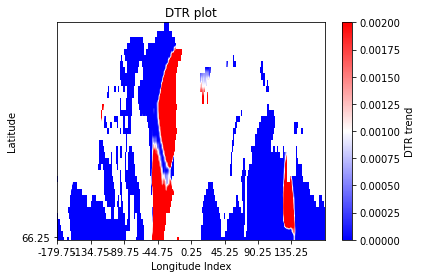

In [ ]:

plt.imshow(data_fit, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='DTR trend')
plt.title('DTR plot')

# Get the latitudes for the y-axis
latitudes = data_fit['lat'].values
longitude = data_fit['lon'].values

# Set the y ticks using the latitudes
plt.yticks(range(len(latitudes))[::50], latitudes[::50])
plt.xticks(range(len(longitude))[::90], longitude[::90])

plt.clim(0,0.002)

plt.xlabel('Longitude Index')
plt.ylabel('Latitude')
#plt.savefig('datacoverage.pdf', dpi = 300)
plt.show()


In [ ]:

# parameters_TDiff = LinReg_All_Month(temperature_diff_selection(lon_min, lon_max), t_s_d, t_s_f, t_e, 'DTR', 'DTR/')


# parameters_TMax = LinReg_All_Month(TMax_selection(lon_min,lon_max), t_s_d, t_s_f, t_e, 'TMax','TMax/')
# parameters_TMin = LinReg_All_Month(TMin_selection(lon_min,lon_max), t_s_d, t_s_f, t_e, 'TMin', 'TMin/')

In [ ]:
# parameters_TDiff['SNR'] =np.abs(parameters_TDiff['slope']/parameters_TDiff['var'])
# parameters_TMax['SNR'] = np.abs(parameters_TMax['slope']/parameters_TMax['var'])
# parameters_TMin['SNR'] = np.abs(parameters_TMin['slope']/parameters_TMin['var'])

### Plots Fitting

### Hearmap

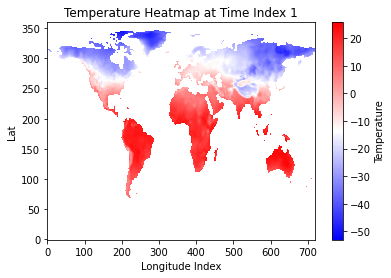

In [ ]:
time_index = 1
temperature_data = TMin.isel(time=time_index).tmn#,lon = range(0,260), lat = range(330,360)).tmn

plt.imshow(temperature_data, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='Temperature')
plt.title(f'Temperature Heatmap at Time Index {time_index}')
plt.xlabel('Longitude Index')
plt.ylabel('Lat')
plt.show()

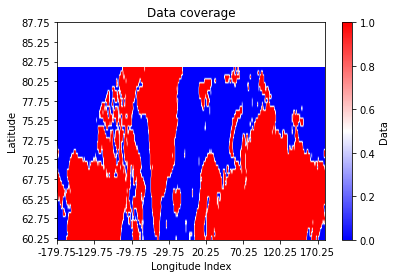

In [ ]:
time_index = '2021-01-16T00:00:00.000000000'
temperature_data = False == np.isnan(TMin.sel(time=time_index, lat=slice(60, 82)).tmn)

plt.imshow(temperature_data, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='Data')
plt.title('Data coverage')

# Get the latitudes for the y-axis
latitudes = TMin.sel(time=time_index, lat=slice(60, 90)).lat.values
longitude = TMin.sel(time=time_index, lat=slice(60, 90)).lon.values

# Set the y ticks using the latitudes
plt.yticks(range(len(latitudes))[::5], latitudes[::5])
plt.xticks(range(len(longitude))[::100], longitude[::100])

plt.xlabel('Longitude Index')
plt.ylabel('Latitude')
#plt.savefig('datacoverage.pdf', dpi = 300)
plt.show()
